# To do list

1 - Calcul de la grid include protein

2 - More pixels (Decaying radii) 20x20x20 --> 254x254x254x15 (memory)!!!! (Mode)

3 - Elements, atom types...

4 - Model explainability (transpose convolutional)

In [69]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
import keras
from sklearn.model_selection import train_test_split
import numpy as np
import collections
from keras.models import model_from_yaml

In [70]:
import istarmap
import h5py
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import glob
import istarmap
from keras.models import model_from_yaml
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling3D, GlobalMaxPooling3D
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, AveragePooling3D
from keras.layers import Dropout, Input, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.models import Model
from sklearn.model_selection import train_test_split
import h5py
import os
from multiprocessing import Pool
from itertools import repeat
import prody as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
from tqdm import tqdm
import subprocess
import glob
from rdkit import Chem
from scipy import sparse
from rdkit.Chem import Descriptors
from itertools import count
import sparse

# Functions and classes

In [71]:
def retrieve_vocabulary_from_sdf(sdfs):
    vocabulary_elements=[]; features=[]
    for sdf in tqdm(sdfs):
        supl = Chem.SDMolSupplier(sdf)
        mols = [mol for mol in supl]
        getatoms = [mol.GetAtoms() for mol in mols]
        elements = set([getatoms[i][x].GetSymbol() for i in range(len(getatoms)) for x in range(len(getatoms[i]))])
        for element in elements:
            if element not in vocabulary_elements:
                vocabulary_elements.append(element)
    vocabulary_elements = {res:i for i, res in enumerate(vocabulary_elements)}
    features = len(vocabulary_elements)
    return  vocabulary_elements, features

In [72]:
class Grid(object):

    def __init__(self, center, side, resolution=None):
        self.center = center
        self.side = side
        self.resolution = resolution
        self.vertexes = self._calculate_vertexes()
    def _calculate_vertexes(self):
        center = self.center
        side = self.side

        vertexes = []
        v1 = center + [-side/2, -side/2, -side/2]
        v2 = center + [side/2, -side/2, -side/2]
        v3 = center + [-side/2, -side/2, side/2]
        v4 = center + [-side/2, side/2, -side/2]
        v5 = center + [side/2, side/2, -side/2]
        v6 = center + [side/2, -side/2, side/2]
        v7 = center + [-side/2, side/2, side/2]
        v8 = center + [side/2, side/2, side/2]
        vertexes.extend([v1, v2, v3, v4, v5, v6, v7, v8])
        return vertexes

    def calculate_pixels(self):
        print("Calculating pixels...")
        rear_back_pixel_center = self.rear_back_pixel_center = self.vertexes[6]  + np.array((self.resolution/2, -self.resolution/2, -self.resolution/2))
        self.n_pixels = n_pixels =  int(self.side / self.resolution)

    def is_point_inside(self, point):
        dist = np.linalg.norm(self.center-point)
        dist_center_diagonal = np.linalg.norm(self.center-self.vertexes[0])
        if dist < dist_center_diagonal:
            return True
        else:
            return False

    def plot(self):
        fig = plt.figure()
        ax = Axes3D(fig)
        for vertex in self.vertexes:
            vx, vy,vz = vertex.tolist()
            ax.scatter(vx, vy, vz)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        return fig.show()


In [73]:
def visualize(result, y_train, nsample):
    npixel = 20
    heat_map_grids = []
    heat_elements_grids = []
    for plane in range(20):
        sample = X_train[nsample][:,:,plane].copy()
        explanation_grid = np.zeros((npixel, npixel)).copy()
        explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += 1
                        explanation_str_grid[i, j] += element
        heat_map_grids.append(explanation_grid)
        heat_elements_grids.append(explanation_str_grid)
    
    final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
    final_grid = np.zeros((npixel, npixel)).copy()
    for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
        final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
        final_grid += grid
    
    print(final_grid_elements)
    
    print("Class", np.argmax(y_train[nsample]), "Prob", y_train[nsample])
    data = final_grid
    plt.matshow(data)
    plt.show()
    

In [74]:
def extract_cnn_input(sdf, center_of_mass, vocabulary_elements, features):

    info = [];
    print("Load trajectory from {}".format(os.path.basename(sdf)))
    supl = Chem.SDMolSupplier(sdf)
    mols = [mol for mol in supl]
    getatoms = [mol.GetAtoms() for mol in mols]
    atoms = [[getatoms[i][x].GetSymbol() for x in range(len(getatoms[i]))] for i in range(len(getatoms))]
    conf = [mol.GetConformer() for mol in mols] # for each molecule in the sdf
    num_atoms = [co.GetNumAtoms() for co in conf]
    pos = np.array([[list(co.GetAtomPosition(num)) for num in range(num_atoms[i])] for i,co in enumerate(conf)])

    print("Find CM of the ligand")


    cm = center_of_mass # finally the mean cm

    side = 20
    print("CM", cm)

    print("Build grid")
    grid2 = Grid(cm, side, 0.5)
    grid2.calculate_pixels()

    #print("Checking created grid")
    #inside = [grid2.is_point_inside for pixel in grid2.pixels]
    #assert  all(inside), "Some point of the grid out of the box check code!"

    # now we only take atoms of ligand in a 20A radius (supposed to be all of them if small)

    lim_dist = 20
    us_atoms = [[atoms[j][i] for i in range(len(atoms[j])) if np.linalg.norm(pos[j][i]- cm) <= lim_dist ] for j in range(len(atoms))]

    print("Filling grid with atom info")
    atoms_all_mols = fill_grid_with_atoms(grid2, mols, us_atoms, cm, vocabulary_elements, features)
    print(len(atoms_all_mols), sdf)
    return [atoms_all_mols, sdf]

In [75]:
def fill_grid_with_atoms(grid2, mols, atoms, cm, vocabulary_elements, features):

    at_all_mols = []; sparse_matrix_dict = {}
    for mol in tqdm(range(len(mols))):
        atoms_per_pixel = np.zeros((grid2.n_pixels, grid2.n_pixels, grid2.n_pixels, features),  dtype=int)
        conf = mols[mol].GetConformer() # for each molecule in the sdf
        num_atoms = conf.GetNumAtoms()
        coords_mol = np.array(list([conf.GetAtomPosition(num) for num in range(num_atoms)]))

        for atom in range(len(atoms[mol])):
            element = atoms[mol][atom]
            coords = coords_mol[atom]

            #assert grid2.is_point_inside(coords), coords

            idxs = np.array([int(abs((x/grid2.resolution))) for x in np.array(np.array(coords) - np.array(grid2.rear_back_pixel_center))])
            #If atom is outside grid
            try:
                atoms_per_pixel[idxs[0]][idxs[1]][idxs[2]]
            except IndexError:
                continue

            pixel = atoms_per_pixel[idxs[0]][idxs[1]][idxs[2]].copy()
            try:
                value =  pixel[vocabulary_elements[element]] + 1
                pixel[vocabulary_elements[element]] = value
            except TypeError:
                value =  1
                pixel[vocabulary_elements[element]] = value

            atoms_per_pixel[idxs[0], idxs[1], idxs[2]] = pixel
        
            index = (idxs[0], idxs[1], idxs[2], vocabulary_elements[element])
            sparse_matrix_dict[index]=value
        sparse_matrix_dict[(grid2.n_pixels-1,grid2.n_pixels-1,grid2.n_pixels-1,features-1)]=0
        x = sparse.COO(sparse_matrix_dict)
        at_all_mols.append(x)
    return at_all_mols



# Extract features

In [76]:
import os

sdfs_lig = glob.glob("input__cluster.c*__dock_lib.sdf")


#Create vocabulary
vocabulary_elements, features = retrieve_vocabulary_from_sdf(sdfs_lig)

np.save("voc", vocabulary_elements)
np.save("feat", features)

#Create COM
coms = []
for sdf in sdfs_lig:
    supl = Chem.SDMolSupplier(sdf)
    mols = [mol for mol in supl]
    getatoms = [mol.GetAtoms() for mol in mols]
    atoms = [[getatoms[i][x].GetSymbol() for x in range(len(getatoms[i]))] for i in range(len(getatoms))]
    conf = [mol.GetConformer() for mol in mols] # for each molecule in the sdf
    num_atoms = [co.GetNumAtoms() for co in conf]
    pos = np.array([[list(co.GetAtomPosition(num)) for num in range(num_atoms[i])] for i,co in enumerate(conf)])
    masses = np.array([Descriptors.MolWt(mol) for mol in mols]) #masses of all the ligands
    centers_of_mass = [np.sum([np.array(getatoms[i][j].GetMass()) * pos[i][j] for j in range(num_atoms[i])], axis=0)/masses[i] for i in range(len(masses))]
    coms.extend(centers_of_mass)

center_grid = np.mean(np.array(coms), axis=0)

assert center_grid.shape[0] == 3



sdfs_lig = [ sdf for sdf in sdfs_lig]
cpus = 5
iterable = zip(sdfs_lig, repeat(center_grid))
#with Pool(cpus) as pool:
    #result = list(tqdm(pool.istarmap(extract_cnn_input, iterable), total=len(sdfs_lig))) #[sdf, vectors]
result = [extract_cnn_input(sdf, center_grid, vocabulary_elements, features) for sdf in sdfs_lig]



 42%|████▏     | 24/57 [00:00<00:00, 237.53it/s]

Load trajectory from input__cluster.c3__dock_lib.sdf
Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


  0%|          | 0/123 [00:00<?, ?it/s]

57 input__cluster.c3__dock_lib.sdf
Load trajectory from input__cluster.c7__dock_lib.sdf
Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


100%|██████████| 123/123 [00:00<00:00, 201.23it/s]


123 input__cluster.c7__dock_lib.sdf
Load trajectory from input__cluster.c0__dock_lib.sdf
Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...


 12%|█▏        | 18/151 [00:00<00:00, 178.98it/s]

Filling grid with atom info


100%|██████████| 151/151 [00:00<00:00, 174.50it/s]


151 input__cluster.c0__dock_lib.sdf
Load trajectory from input__cluster.c4__dock_lib.sdf


 11%|█▏        | 22/195 [00:00<00:00, 218.78it/s]

Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


100%|██████████| 195/195 [00:01<00:00, 159.91it/s]


195 input__cluster.c4__dock_lib.sdf
Load trajectory from input__cluster.c9__dock_lib.sdf
Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...


 14%|█▍        | 21/146 [00:00<00:00, 205.96it/s]

Filling grid with atom info


100%|██████████| 146/146 [00:00<00:00, 165.09it/s]


146 input__cluster.c9__dock_lib.sdf
Load trajectory from input__cluster.c8__dock_lib.sdf


 12%|█▏        | 20/163 [00:00<00:00, 199.85it/s]

Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


100%|██████████| 163/163 [00:00<00:00, 177.20it/s]


163 input__cluster.c8__dock_lib.sdf
Load trajectory from input__cluster.c5__dock_lib.sdf


 13%|█▎        | 20/158 [00:00<00:00, 197.97it/s]

Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


  0%|          | 0/80 [00:00<?, ?it/s]

158 input__cluster.c5__dock_lib.sdf
Load trajectory from input__cluster.c1__dock_lib.sdf
Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


100%|██████████| 80/80 [00:00<00:00, 220.49it/s]


80 input__cluster.c1__dock_lib.sdf
Load trajectory from input__cluster.c6__dock_lib.sdf


 10%|█         | 16/160 [00:00<00:00, 159.40it/s]

Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


100%|██████████| 160/160 [00:01<00:00, 145.51it/s]


160 input__cluster.c6__dock_lib.sdf
Load trajectory from input__cluster.c2__dock_lib.sdf


 10%|█         | 19/181 [00:00<00:00, 187.48it/s]

Find CM of the ligand
CM [42.48995211 43.93740209 36.83727789]
Build grid
Calculating pixels...
Filling grid with atom info


100%|██████████| 181/181 [00:01<00:00, 166.95it/s]

181 input__cluster.c2__dock_lib.sdf


In [77]:
actives = "actives.sdf"
inactives = "decoys_final.sdf"
with open(actives, "r") as f:
    data = f.readlines()
    ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
    ids[-1] = 0 # first line contains a name, but not the last
    acts = [data[idx].split('\n')[0] for idx in ids]
with open(inactives, "r") as f:
    data = f.readlines()
    ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
    ids[-1] = 0
    inacts = [data[idx].split('\n')[0] for idx in ids]


In [78]:
X = []; Y = []
tot = 0
for clust, sdf in tqdm(result): # for each cluster
    ii = 0
    toremove = []
    with open(sdf, "r") as f:
        data = f.readlines()
        ids = np.array([i+1 for i, j in zip(count(), data) if j == '$$$$\n'])
        ids[-1] = 0 # first line contains a name, but not the last
        names = [data[idx].split('\n')[0] for idx in ids]
    for i,x in tqdm(enumerate(clust)): # for each mol in the cluster
        if names[i] in acts:
            Y.append(1)
            X.append(x)
            ii += 1;
        if names[i] in inacts:
            Y.append(0)
            X.append(x)
            ii += 1;
        if names[i] not in acts and names[i] not in inacts:
            print('Unexpected name (usually cluster...)', names[i])
            toremove.append(names[i])
    for rm in toremove: names.remove(rm)
    print(sdf, ii, len(names))
    
y_train = keras.utils.to_categorical(Y, 2)

"""
num, x, y, z, l = list(np.array(X).shape)
print(num, x, y, z, l)

X_train = X


print(y_train)

#np.save("Xtrain", np.array(X_train))
#np.save("Ytrain", np.array(y_train))
"""

  0%|          | 0/10 [00:00<?, ?it/s]
57it [00:00, 7799.66it/s]

123it [00:00, 6012.04it/s]
 20%|██        | 2/10 [00:00<00:00, 18.24it/s]
151it [00:00, 6829.49it/s]

195it [00:00, 7444.76it/s]

146it [00:00, 7560.76it/s]
 50%|█████     | 5/10 [00:00<00:00, 20.60it/s]
163it [00:00, 7034.67it/s]

0it [00:00, ?it/s]

input__cluster.c3__dock_lib.sdf 57 57
Unexpected name (usually cluster...) cluster.c1 ligand
Unexpected name (usually cluster...) cluster.c2 ligand
Unexpected name (usually cluster...) cluster.c3 ligand
Unexpected name (usually cluster...) cluster.c4 ligand
Unexpected name (usually cluster...) cluster.c5 ligand
Unexpected name (usually cluster...) cluster.c6 ligand
Unexpected name (usually cluster...) cluster.c7 ligand
Unexpected name (usually cluster...) cluster.c8 ligand
Unexpected name (usually cluster...) cluster.c9 ligand
Unexpected name (usually cluster...) cluster.c0 ligand
input__cluster.c7__dock_lib.sdf 113 113
Unexpected name (usually cluster...) cluster.c0 ligand
Unexpected name (usually cluster...) cluster.c1 ligand
Unexpected name (usually cluster...) cluster.c2 ligand
Unexpected name (usually cluster...) cluster.c3 ligand
Unexpected name (usually cluster...) cluster.c4 ligand
Unexpected name (usually cluster...) cluster.c5 ligand
Unexpected name (usually cluster...) clust

158it [00:00, 5723.59it/s]

80it [00:00, 7736.25it/s]
 80%|████████  | 8/10 [00:00<00:00, 22.24it/s]
160it [00:00, 6314.58it/s]

181it [00:00, 6815.05it/s]
100%|██████████| 10/10 [00:00<00:00, 24.87it/s]

input__cluster.c5__dock_lib.sdf 148 148
Unexpected name (usually cluster...) cluster.c0 ligand
Unexpected name (usually cluster...) cluster.c1 ligand
Unexpected name (usually cluster...) cluster.c2 ligand
Unexpected name (usually cluster...) cluster.c3 ligand
Unexpected name (usually cluster...) cluster.c4 ligand
Unexpected name (usually cluster...) cluster.c5 ligand
Unexpected name (usually cluster...) cluster.c6 ligand
Unexpected name (usually cluster...) cluster.c7 ligand
Unexpected name (usually cluster...) cluster.c8 ligand
Unexpected name (usually cluster...) cluster.c9 ligand
input__cluster.c1__dock_lib.sdf 70 70
Unexpected name (usually cluster...) cluster.c0 ligand
Unexpected name (usually cluster...) cluster.c1 ligand
Unexpected name (usually cluster...) cluster.c2 ligand
Unexpected name (usually cluster...) cluster.c3 ligand
Unexpected name (usually cluster...) cluster.c4 ligand
Unexpected name (usually cluster...) cluster.c5 ligand
Unexpected name (usually cluster...) clust

'\nnum, x, y, z, l = list(np.array(X).shape)\nprint(num, x, y, z, l)\n\nX_train = X\n\n\nprint(y_train)\n\n#np.save("Xtrain", np.array(X_train))\n#np.save("Ytrain", np.array(y_train))\n'

(array([611.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 713.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

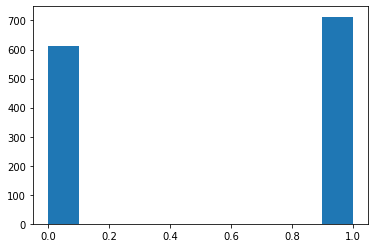

In [79]:
plt.hist(Y)

In [80]:
print("Build model")
model = Sequential()
input_layer = Input((40,40,40,9)) 



## convolutional layers
conv_layer1 = Conv3D(filters=32, kernel_size=(2, 2, 2), padding="same", activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=32, kernel_size=(2, 2, 2),padding="same", activation='relu')(conv_layer1)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

## add max pooling to obtain the most imformatic features
conv_layer3 = Conv3D(filters=64, kernel_size=(2, 2, 2),padding="same", activation='relu')(pooling_layer1)
conv_layer4 = Conv3D(filters=64, kernel_size=(2, 2, 2),padding="same", activation='relu')(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)


## add max pooling to obtain the most imformatic features
conv_layer5 = Conv3D(filters=128, kernel_size=(2, 2, 2), padding="same",activation='relu')(pooling_layer2)
conv_layer6 = Conv3D(filters=128, kernel_size=(2, 2, 2),padding="same", activation='relu')(conv_layer5)
pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer6)

## perform batch normalization on the convolution outputs before feeding it to MLP architecture
pooling_layer4 = BatchNormalization()(pooling_layer3)
flatten_layer = Flatten()(pooling_layer4)

## create an MLP architecture with dense layers : 4096 -> 512 -> 10
## add dropouts to avoid overfitting / perform regularization
#dense_layer1 = Dense(units=2048, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(flatten_layer)
dense_layer2 = Dense(units=512, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=2, activation='softmax')(dense_layer2)


## define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=0.1), metrics=['acc'])








Build model


In [81]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indexes =  np.arange(np.shape(self.labels)[0])

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        
        print("iteration", index)
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        X = [self.list_IDs[k].todense() for k in indexes]
        y = [self.labels[k, :] for k in indexes]
        
        return np.array(X), np.array(y)

In [82]:
params = {'dim': (20,20,20),
          'batch_size': 10,
          'n_classes': 2,
          'n_channels': 9,
          'shuffle': False}


#training_generator = DataGenerator(X[0:20], y_train[0:20], **params)





In [ ]:
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
history = History()
model.fit_generator(generator=DataGenerator(X, y_train, **params),  epochs=10)

Epoch 1/10
iteration 129
iteration 40
iteration 59
iteration 5
iteration 126
iteration 60
iteration 117
iteration 4
iteration 96
iteration 106
iteration 119
iteration 21
 85/132 [==================>...........] - ETA: 3:08 - loss: 0.7422 - acc: 0.5129iteration 121


129/132 [============================>.] - ETA: 11s - loss: 0.7294 - acc: 0.5078

In [34]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = len(X_data)
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    print(index, number_of_batches)
    while True:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        values = X_data[0]
        X_batch = [X_data[i].todense() for i in index_batch]
        y_batch = [y_data[i,:]  for i in index_batch]
        counter += 1
        print((np.array(X_batch).reshape(len(X_batch), 200,200, 200,9).shape, np.array(y_batch).shape))
        yield(np.array(X_batch).reshape(len(X_batch), 200,200, 200,9), np.array(y_batch))
        if (counter >= number_of_batches):
            print("restart")
            counter=0

In [ ]:
print("Fit model")
print(len(X[0:10])// batch_size)
batch_size=5
generator = nn_batch_generator(X[0:10], y_train[0:10], batch_size)

model.fit_generator(generator,
                    nb_epoch=50, 
                    samples_per_epoch=10, verbose=1)

Fit model
2
Epoch 1/50
[0 1 2 3 4 5 6 7 8 9] 2.0


/Users/nostrum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/Users/nostrum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, steps_per_epoch=10, epochs=50)`
  


((5, 200, 200, 200, 9), (5, 2))
((5, 200, 200, 200, 9), (5, 2))
((0, 200, 200, 200, 9), (0,))
restart
((5, 200, 200, 200, 9), (5, 2))
((5, 200, 200, 200, 9), (5, 2))
((0, 200, 200, 200, 9), (0,))
restart
((5, 200, 200, 200, 9), (5, 2))
((5, 200, 200, 200, 9), (5, 2))
((0, 200, 200, 200, 9), (0,))
restart
((5, 200, 200, 200, 9), (5, 2))


## Pick up previous model and  data

In [268]:
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(loaded_model_yaml)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [269]:
X_train = np.load("Xtrain.npy", allow_pickle=True)
y_train = np.load("Ytrain.npy", allow_pickle=True)
vocabulary_elements = np.load("voc.npy", allow_pickle=True).item()
features = np.load("feat.npy", allow_pickle=True)

In [270]:
img, x, y, z, l = list(np.array(X_train).shape)

In [271]:
model.compile(loss=categorical_crossentropy, optimizer=Adadelta(lr=1), metrics=['acc'])

# Predict on training

In [236]:
model.evaluate(np.array(X_train), np.array(y_train))

1324/1324 [==============================] - 10s 7ms/step


[0.6930233004230026, 0.6669184565544128]

In [237]:
preds = model.predict(np.array(X_train))

(array([294., 158., 117.,  97.,  82., 101.,  82.,  90., 128., 175.]),
 array([5.1977014e-04, 1.0021017e-01, 1.9990057e-01, 2.9959098e-01,
        3.9928138e-01, 4.9897176e-01, 5.9866220e-01, 6.9835258e-01,
        7.9804295e-01, 8.9773339e-01, 9.9742377e-01], dtype=float32),
 <a list of 10 Patch objects>)

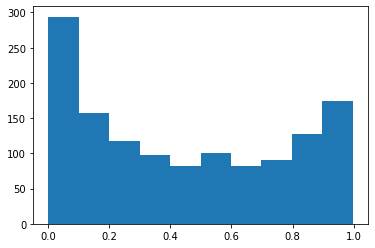

In [238]:
plt.hist(preds[:,1])

In [239]:
from sklearn.metrics import classification_report, confusion_matrix
Y = [np.argmax(y) for y in y_train]
confusion_matrix(Y, [np.argmax(pred) for pred in preds])

array([[460, 151],
       [290, 423]])

# Sensitivity analysis

## All elements

Count the average of how many times an atom show up in the structure

In [240]:
import glob
from rdkit import Chem
sdfs_lig = glob.glob("input__cluster.c*__dock_lib.sdf")

In [241]:
counters = []
for sdf in sdfs_lig:
    for mol in Chem.SDMolSupplier(sdf, removeHs=False):
        elements =  [atom.GetSymbol() for atom in mol.GetAtoms()]
        counter = collections.Counter(elements)
        counters.append(counter)

    
    
    

In [251]:
average_elements = vocabulary_elements.copy()
for i in vocabulary_elements.keys():
    average_elements[i] = np.mean([counter[i] for counter in counters])
average_elements 

assert average_elements["C"] == 18.418670438472418

average_elements

{'C': 18.418670438472418,
 'N': 2.611032531824611,
 'Cl': 0.31824611032531824,
 'F': 0.4872701555869873,
 'O': 2.2043847241867045,
 'S': 0.5487977369165488,
 'Br': 0.10113154172560113,
 'I': 0.019801980198019802,
 'P': 0.0007072135785007072}

Count How many times an atom show up in a pdb

In [252]:
element_in_pdbs = average_elements.copy()
for i in vocabulary_elements.keys():
    pdbs_with_element = 0
    for counter in counters:
        if counter[i] != 0:
            pdbs_with_element += 1
    element_in_pdbs[i] = pdbs_with_element

    

Generate feature importance by doing: drop_on_accuracy*pdbs_with_atom/number_of_atoms_in_pdb

In [253]:
ac1 = model.evaluate(X_train, y_train)
preds = model.predict(X_train)

1324/1324 [==============================] - 9s 7ms/step


In [255]:
importances_dict = vocabulary_elements.copy()
for element in tqdm(vocabulary_elements.keys()):
    new_X_train =  X_train.copy()
    channel = vocabulary_elements[element]
    
    #Removing channel from all samples
    for i, sample in enumerate(new_X_train):
        for r in range(x):
            for j in range(y):
                for k in range(l):
                    if new_X_train[i][r,j,k, channel] != 0:
                        new_X_train[i][r,j,k, channel] = 0
                        
    #Checking it was done succesfully                    
    for i, sample in enumerate(new_X_train):
        for r in range(x):
            for j in range(y):
                for k in range(l):
                    assert new_X_train[i][r,j,k, channel] == 0, (i,r,j,k)
                    
    #Calculating importance            
    ac2 = model.evaluate(new_X_train, y_train)
    importance = ac2[0]-ac1[0]
    importances_dict[element] =  importance/average_elements[element]
                

  0%|          | 0/9 [00:00<?, ?it/s]

1324/1324 [==============================] - 9s 7ms/step


 11%|█         | 1/9 [00:16<02:14, 16.78s/it]

1324/1324 [==============================] - 9s 7ms/step


 22%|██▏       | 2/9 [00:32<01:56, 16.61s/it]

1324/1324 [==============================] - 9s 7ms/step


 33%|███▎      | 3/9 [00:48<01:38, 16.42s/it]

1324/1324 [==============================] - 9s 7ms/step


 44%|████▍     | 4/9 [01:05<01:22, 16.50s/it]

1324/1324 [==============================] - 10s 7ms/step


 56%|█████▌    | 5/9 [01:22<01:06, 16.54s/it]

1324/1324 [==============================] - 9s 7ms/step


 67%|██████▋   | 6/9 [01:39<00:49, 16.63s/it]

1324/1324 [==============================] - 9s 7ms/step


 78%|███████▊  | 7/9 [01:55<00:33, 16.62s/it]

1324/1324 [==============================] - 9s 7ms/step


 89%|████████▉ | 8/9 [02:12<00:16, 16.54s/it]

1324/1324 [==============================] - 9s 7ms/step


100%|██████████| 9/9 [02:28<00:00, 16.49s/it]


## Importance*appearance

<BarContainer object of 9 artists>

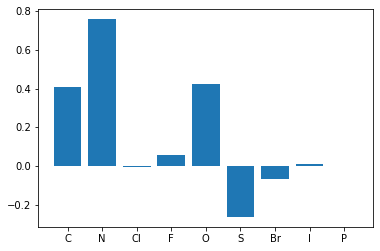

In [256]:
importance_values = [importances_dict[element]*element_in_pdbs[element] for element in importances_dict.keys()]
norm = np.linalg.norm(importance_values)
plt.bar(importances_dict.keys(), (importance_values/norm))
                    

## Importance

<BarContainer object of 9 artists>

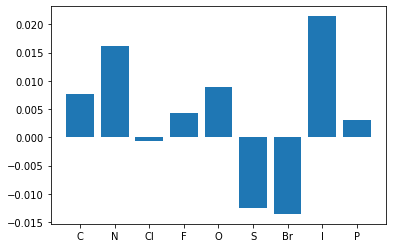

In [257]:
plt.bar(importances_dict.keys(), (importances_dict.values()))

## Appereance

<BarContainer object of 9 artists>

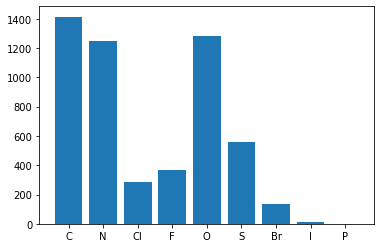

In [258]:
plt.bar(importances_dict.keys(), (element_in_pdbs.values()))

## One element

In [110]:
nsample=0

sample = X_train.copy()[nsample]

xs, ys, ls, _ = sample.shape

key = "N"; channel = vocabulary_elements[key]

idxs_dict = vocabulary_elements.copy();

print(result[nsample][1])

#First prediction
pred = model.predict(np.array(sample).reshape(1, 20, 20, 20, 9))[0]
label_pred = np.argmax(pred)
prob = pred[label_pred]


# CHeck atoms with that channel
idxs = []
for r in range(xs):
    for k in range(ys):
        for m in range(ls):
            if sample[r, k, m, channel] != 0:
                print("A")
                idxs.append([r,k,m])
                idxs_dict[key] = idxs
                print(idxs_dict)


# Remove one atom at a time
importances_per_atom = []
for idxs in idxs_dict[key]:
    x,y,z = idxs
    position = rear_bck_pixel + np.array([+x+1,-y,-z])
    print(position)
    new_sample = X_train.copy()[nsample]
    new_sample[x,y,z,channel] = 0
    pred = model.predict(np.array(new_sample).reshape(1, 20, 20, 20, 9))[0]
    importance = prob - pred[label_pred]
    importances_per_atom.append(importance)
importances_per_atom

input__cluster.c3__dock_lib.sdf
A
{'S': 0, 'Br': 1, 'C': 2, 'Cl': 3, 'N': [[7, 10, 10]], 'F': 5, 'O': 6, 'I': 7, 'P': 8}
A
{'S': 0, 'Br': 1, 'C': 2, 'Cl': 3, 'N': [[7, 10, 10], [8, 11, 9]], 'F': 5, 'O': 6, 'I': 7, 'P': 8}
A
{'S': 0, 'Br': 1, 'C': 2, 'Cl': 3, 'N': [[7, 10, 10], [8, 11, 9], [11, 4, 4]], 'F': 5, 'O': 6, 'I': 7, 'P': 8}


NameError: name 'rear_bck_pixel' is not defined

## On pixels

In [116]:
side = 20
cm=np.array([42.48995211, 43.93740209, 36.83727789])
grid2 = Grid(cm, side, 1)
grid2.calculate_pixels()
rear_bck_pixel=grid2.rear_back_pixel_center

Calculating pixels...


In [118]:
pred_baseline = model.predict(np.array(sample).reshape(1, 20, 20, 20, 9))[0]
label = np.argmax(pred_baseline)

nsamples, x,y,z,_ = X_train.shape
blank_pixel = np.zeros(9)

importance_pixel = np.zeros((x,y,z))


for coordx in tqdm(range(x)):
    for coordy in range(y):
        for coordz in range(z):
            if 1 in X_train[nsample][coordx,coordy,coordz]:
                new_X_train=X_train.copy()
                importance = [];  new_train = X_train.copy()
                new_train[nsample][coordx,coordy,coordz] = blank_pixel
                pred = model.predict(new_train[nsample].reshape(1, 20, 20, 20, 9))[0]
                print(pred_baseline[label], pred[label])
                importance_single_pixel = pred_baseline[label]-pred[label]
                print(importance_single_pixel)
            else:
                importance_single_pixel=0
                print(importance_single_pixel)
            importance_pixel[coordx,coordy,coordz] = importance_single_pixel
            


 10%|█         | 2/20 [00:00<00:00, 19.45it/s]

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 25%|██▌       | 5/20 [00:00<00:00, 21.58it/s]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

 40%|████      | 8/20 [00:02<00:03,  3.65it/s]

0.55232936 0.63160706
-0.079277694
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.55764157
-0.0053122044
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5570642
-0.004734814
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.58212245
-0.029793084
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.7213726
-0.16904324
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

 45%|████▌     | 9/20 [00:11<00:29,  2.71s/it]

0.55232936 0.43982798
0.11250138
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5689073
-0.016577959
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.45305187
0.0992775
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.60872585
-0.056396484
0.55232936 0.5374114
0.01491797
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 50%|█████     | 10/20 [00:18<00:40,  4.00s/it]

0.55232936 0.6884104
-0.13608104
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.52825314
0.024076223
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5417971
0.01053226
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5008712
0.05145818
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.57751024
-0.025180876
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5257683
0.026561081
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 55%|█████▌    | 11/20 [00:25<00:45,  5.11s/it]

0.55232936 0.6457658
-0.09343642
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5399976
0.012331784
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5197737
0.03255564
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.63015336
-0.077824
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.6315576
-0.07922822
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 60%|██████    | 12/20 [00:32<00:44,  5.54s/it]

0.55232936 0.5312639
0.021065474
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.56355757
-0.011228204
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0.55232936 0.5460063
0.0063230395
0.55232936 0.58814895
-0.03581959
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


 80%|████████  | 16/20 [00:37<00:15,  3.82s/it]

0.55232936 0.599961
-0.04763162
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


100%|██████████| 20/20 [00:37<00:00,  1.89s/it]


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [128]:
x, y, z = np.unravel_index(np.argsort(importance_pixel, axis=None), importance_pixel.shape)

In [145]:
idx_imp = 2
idx = [x[-idx_imp], y[-idx_imp], z[-idx_imp]]
importance = importance_pixel[x[-idx_imp], y[-idx_imp], z[-idx_imp]]
print(importance, idx, rear_bck_pixel + np.array([+x[-idx_imp]+1,-y[-idx_imp],-z[-idx_imp]]))

0.11250138282775879 [8, 11, 9] [41.98995211 42.43740209 37.33727789]


In [200]:
def visualize(result, y_train, nsample):
    npixel = 20
    heat_map_grids = []
    heat_elements_grids = []
    for plane in range(20):
        sample = X_train[nsample][:,:,plane].copy()
        explanation_grid = np.zeros((npixel, npixel)).copy()
        explanation_str_grid = np.empty((npixel, npixel), dtype="<U5")
        x, y, channels = sample.shape


        key_list = list(vocabulary_elements.keys()) 
        val_list = list(vocabulary_elements.values())

        for i in range(x):
            for j in range(y):
                for k in range(channels):
                    channel = sample[i, j, k]
                    if channel != 0:
                        element = key_list[val_list.index(k)]
                        explanation_grid[i, j] += 1
                        explanation_str_grid[i, j] += element
        heat_map_grids.append(explanation_grid)
        heat_elements_grids.append(explanation_str_grid)
    
    final_grid_elements = np.empty((npixel, npixel), dtype="<U5")
    final_grid = np.zeros((npixel, npixel)).copy()
    for grid_el, grid in zip(heat_elements_grids, heat_map_grids):
        final_grid_elements = np.core.defchararray.add(final_grid_elements, grid_el)
        final_grid += grid
    
    print(final_grid_elements)
    
    print("Class", np.argmax(y_train[nsample]), "Prob", y_train[nsample])
    data = final_grid
    plt.matshow(data)
    plt.show()

In [201]:
vocabulary_elements

{'C': 0, 'N': 1, 'Cl': 2, 'F': 3, 'O': 4, 'S': 5, 'Br': 6, 'I': 7, 'P': 8}

In [140]:
X_train[nsample][x[-idx_imp], y[-idx_imp], z[-idx_imp]]

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

# Visualize Filters

As many dimensions as filter X channel --> Too many

In [272]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20, 20, 20, 9)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 20, 20, 20, 32)    2336      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 20, 20, 32)    8224      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 10, 10, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 10, 10, 64)    16448     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 10, 10, 10, 64)    32832     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 5, 5, 64)       0   

In [273]:
convolutionals_layers = []
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    else:
        convolutionals_layers.append(layer)
convolutionals_layers

In [274]:
for layer in convolutionals_layers:
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv3d_1 (2, 2, 2, 9, 32)
conv3d_2 (2, 2, 2, 32, 32)
conv3d_3 (2, 2, 2, 32, 64)
conv3d_4 (2, 2, 2, 64, 64)
conv3d_5 (2, 2, 2, 64, 256)
conv3d_6 (2, 2, 2, 256, 256)


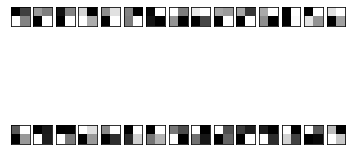

In [275]:
# cannot easily visualize filters lower down
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
# retrieve weights from the second hidden layer
filters, biases = convolutionals_layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 2, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(15):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 15, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        final_filter = np.zeros((f.shape[0], f.shape[1], f.shape[3]))
        for i in range(f.shape[2]):
            final_filter += f[:,:,i, :]
        pyplot.imshow(final_filter[:, :, j], cmap='gray')
        ix += 1
# show the figure
pyplot.show()

# Feature Map

/Users/nostrum/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


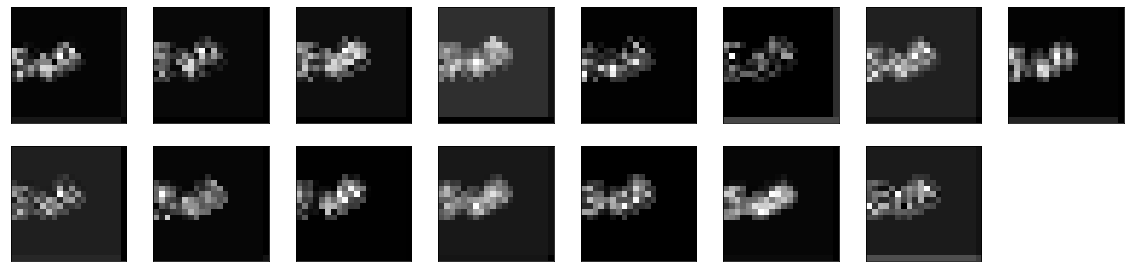

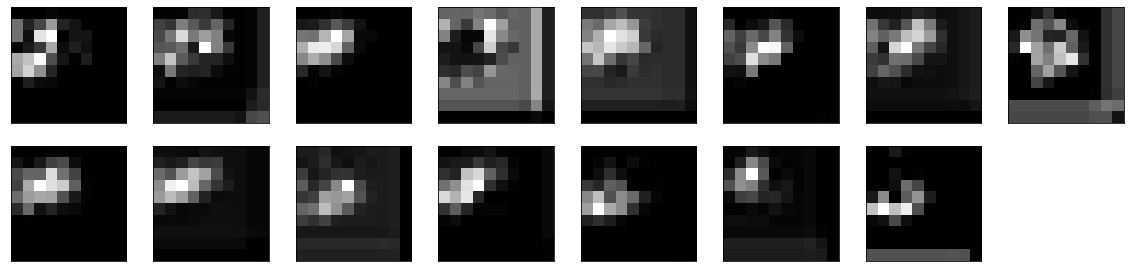

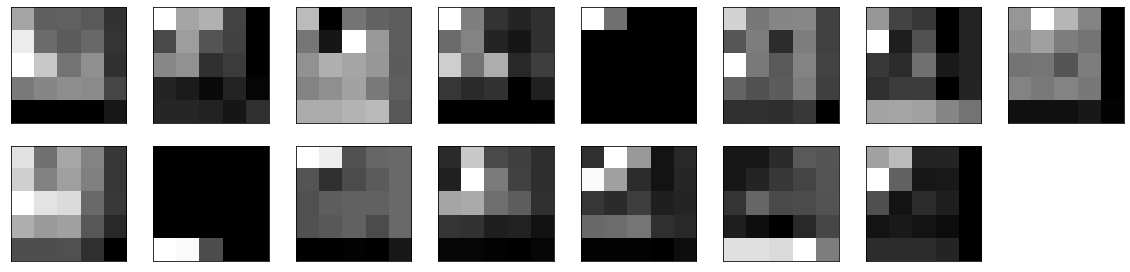

In [277]:
# redefine model to output right after the first hidden layer
ixs = [2, 5, 8]
outputs = [model.layers[i].output for i in ixs]
model1 = Model(inputs=model.inputs, outputs=outputs)
samples = X_train[0]
feature_maps = model1.predict(samples.reshape(1, 20, 20, 20, 9))
# plot the output from each block




for fmap in feature_maps:
    # plot all 64 maps in an 8x8 squares
    fig = plt.figure(figsize=(x, y))
    ix = 1
    for _ in range(15):
        # specify subplot and turn of axis
        ax = pyplot.subplot(8, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in gray scale
        final_map = np.zeros((fmap.shape[1], fmap.shape[2], fmap.shape[4]))
        for i in range(fmap.shape[3]):
            final_map += fmap[0, :,:, i, :]
        pyplot.imshow(final_map[:, :, ix-1], cmap='gray')
        ix += 1
# show the figure
    fig.show()

# CMAP

https://github.com/nickbiso/Keras-Class-Activation-Map/blob/master/Class%20Activation%20Map(CAM).ipynb

In [283]:
from keras import backend as K

nsample=0

print(nsample)
#Prediction
argmax = np.argmax(preds[nsample])
#Probability
probability = preds[nsample][argmax]
#Output
output = model.output[:, argmax]
#Las convulutional layer
last_conv_layer = model.get_layer('conv3d_2')
#Intensity of the channels
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_train])

0


In [284]:
#For each channel we multiply for its intensity
for i in range(conv_layer_output_value.shape[2]):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' 'N' '' '' '' '' '' '' '' '' '']
 ['' 'C' 'C' 'C' '' '' '' '' '' 'C' '' 'CN' '' '' '' '' '' '' '' '']
 ['' 'C' '' '' '' '' 'O' '' '' 'CC' '' '' 'C' '' '' '' '' '' '' '']
 ['' '' 'C' 'C' '' 'C' '' 'C' '' '' 'C' 'C' '' '' '' '' '' '' '' '']
 ['' '' '' '' 'N' '' 'C' 'C' 'C' 'C' '' '' '' '' '' '' '' '' '' '']
 ['O' '' 'CO' '' '' '' '' 'C' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' ''

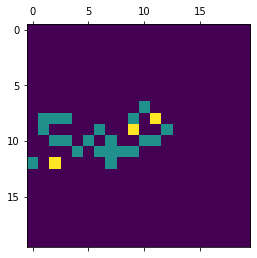

In [285]:
visualize(X_train, y_train, 0)

Class 1 Prob 0.7665937
(20, 20)


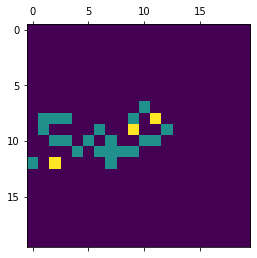

In [186]:
print("Class", argmax, "Prob", probability)
data = final_grid
plt.matshow(data)
plt.show()

In [286]:
output = np.zeros(conv_layer_output_value[:,:,1].shape)
for i in range(conv_layer_output_value.shape[2]):
    output += conv_layer_output_value[:,:,i]
output

array([[[-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e-06, -1.56900913e-05],
        [-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e-06, -1.56900913e-05],
        [-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e-06, -1.56900913e-05],
        ...,
        [-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e-06, -1.56900913e-05],
        [-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e-06, -1.56900913e-05],
        [-8.30649983e-06,  0.00000000e+00,  0.00000000e+00, ...,
         -7.67391140e-06,  0.00000000e+00, -2.07715836e-05]],

       [[-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e-06, -1.56900913e-05],
        [-6.16222621e-06, -1.70372365e-06, -2.47778638e-06, ...,
         -2.74407821e-07, -4.09949826e

Predicted Class 1 Real Class 1 Prob 0.9119578


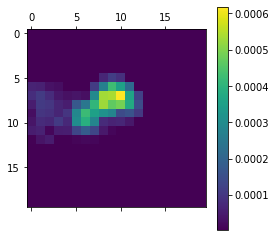

In [287]:
import cv2
print("Predicted Class", argmax, "Real Class", Y[0], "Prob", probability)
heatmap = abs(np.mean(output, axis=-1))
#heatmap = np.maximum(heatmap, 0)
#heatmap /= np.max(heatmap)
heatmap = cv2.resize(heatmap, (20, 20), interpolation = cv2.INTER_CUBIC)
plt.matshow(heatmap)
plt.colorbar()
plt.show()



In [67]:
#heatmap = np.uint8(255 * heatmap)
#heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
#data = cv2.applyColorMap(data, cv2.COLORMAP_BONE)
heatmap_norm = np.maximum(heatmap, 0)
heatmap_norm /= np.max(heatmap_norm)
superimposed_img =  7*heatmap_norm +  data
plt.imshow(superimposed_img)


NameError: name 'data' is not defined

In [269]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(32, 2)

In [296]:
cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))

In [297]:
cam_model.summary()

Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        (None, 15, 15, 15, 9)     0         
_________________________________________________________________
conv3d_78 (Conv3D)           (None, 13, 13, 13, 16)    3904      
_________________________________________________________________
conv3d_79 (Conv3D)           (None, 11, 11, 11, 32)    13856     
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 5, 5, 5, 32)       0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 5, 5, 5, 32)       128       
_________________________________________________________________
flatten_17 (Flatten)         (None, 4000)              0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 4000)              0  

In [283]:
features,results = cam_model.predict(X_train)
features.shape, results.shape

((1223, 11, 11, 11, 32), (1223, 2))

In [284]:
results

array([[0.71341306, 0.286587  ],
       [0.70353806, 0.29646197],
       [0.72362846, 0.27637154],
       ...,
       [0.72155726, 0.27844274],
       [0.71080273, 0.28919727],
       [0.7032597 , 0.29674023]], dtype=float32)

In [285]:
for i, result in enumerate(results):
    if np.argmax(result) == 1:
        print(i)

In [252]:
for idx in range(2):
    features_for_one_img = features[idx,:,:,:]
    #height_roomout = X_train.shape[1]/features_for_one_img.shape[0]
    #width_roomout  = X_train.shape[2]/features_for_one_img.shape[1]
    #print(height_roomout,width_roomout)
 
    #cam_features = sp.ndimage.zoom(features_for_one_img, (height_roomout, width_roomout, 1), order=2)
    #print(cam_features.shape)
    pred = np.argmax(results[idx])
    cam_features = features_for_one_img
    
    
    plt.figure(facecolor='white')
    cam_weights = gap_weights[:,pred]
    cam_output  = np.dot(cam_features,cam_weights)
    #print(features_for_one_img.shape)

    buf = 'Predicted Class = ' +str( pred )+ ', Probability = ' + str(results[idx][pred])

    

    #plt.imshow(np.squeeze(X_train[idx],-1), alpha=0.5)

    for i in range(6):
        plt.figure(facecolor='white')
        new_buf  = buf + "plane {}".format(i)
        plt.xlabel(new_buf)
        plt.imshow(cam_output[:,:,i], cmap='jet', alpha=0.5)


ValueError: shapes (11,11,11,32) and (4000,) not aligned: 32 (dim 3) != 4000 (dim 0)

<Figure size 432x288 with 0 Axes>

In [151]:
print(explanation_grid)

[['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' 'O' '' '' '' '' '' '']
 ['' '' '' '' '' '' 'O' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' 'O' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]


In [116]:
sample

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [112]:
vocabulary_elements

{'C': 0, 'O': 1, 'H': 2, 'Cl': 3, 'N': 4, 'F': 5, 'Br': 6, 'I': 7, 'S': 8}